In [1]:
import xtrack as xt

import json
import numpy as np

line = xt.Line.from_json('sler_1705_60_06_cw50_4b_edited.json')
line.particle_ref = xt.Particles(p0c=4e9, mass0=xt.ELECTRON_MASS_EV)

# Load SAD twiss table
twiss_fname = 'sler_1705_60_06_cw50_4b.twiss.json'
with open(twiss_fname, 'r') as f:
    tw_dict = json.load(f)

tw_dict['Element'] = np.array([nn.lower() for nn in tw_dict['Element']])

tw_sad = xt.Table(
        {
            'name': np.array(tw_dict['Element']),
            's':    np.array(tw_dict['s(m)']),
            'betx': np.array(tw_dict['BX']),
            'alfx': np.array(tw_dict['AX']),
            'bety': np.array(tw_dict['BY']),
            'alfy': np.array(tw_dict['AY']),
            'mux':  np.array(tw_dict['NX']),
            'muy':  np.array(tw_dict['NY']),
            'dx':   np.array(tw_dict['EX']),
            'dy':   np.array(tw_dict['EY']),
            'dpx':  np.array(tw_dict['EPX']),
            'dpy':  np.array(tw_dict['EPY']),
        })

tt = line.get_table()
elems_in_common = np.intersect1d(tw_sad['name'], tt.name)

tt_common = tt.rows[elems_in_common]
tsad_common = tw_sad.rows[elems_in_common]

# Load SAD survey
with open('sler_1705_60_06_cw50_4b.dispg.json', 'r') as f:
    sv_sad = json.load(f)

line.build_tracker()

sv = line.survey()

Loading line from dict:   0%|          | 0/8414 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


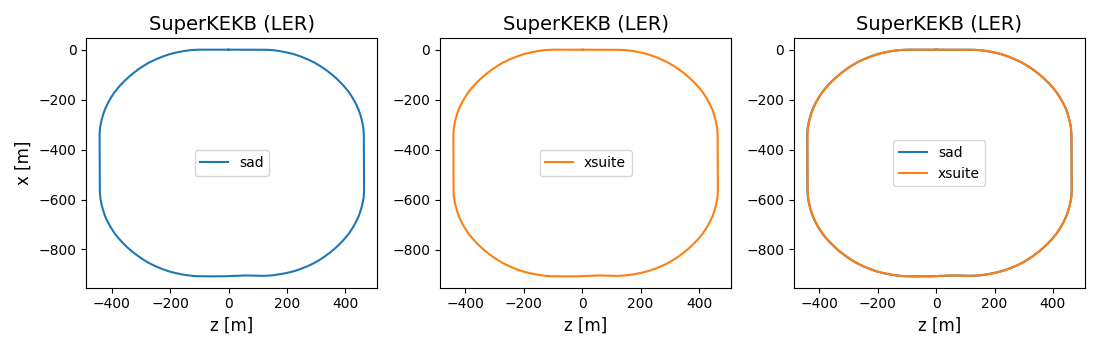

In [2]:
# Plot survey

%matplotlib widget
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(11, 3.5))

# SAD survey
Gx = np.array(sv_sad['Gx'])
Gy = np.array(sv_sad['Gy'])
Gz = np.array(sv_sad['Gz'])

ax[0].plot(Gx, -Gy, label='sad')

ax[0].set_title('SuperKEKB (LER)', fontsize=14)
ax[0].set_xlabel('z [m]', fontsize=12)
ax[0].set_ylabel('x [m]', fontsize=12)

ax[0].legend()


ax[1].plot([], [])
ax[1].plot(sv.Z, sv.X, label='xsuite')

ax[1].set_title('SuperKEKB (LER)', fontsize=14)
ax[1].set_xlabel('z [m]', fontsize=12)

ax[1].legend()


ax[2].plot(Gx, -Gy, label='sad')
ax[2].plot(sv.Z, sv.X, label='xsuite')

ax[2].set_title('SuperKEKB (LER)', fontsize=14)
ax[2].set_xlabel('z [m]', fontsize=12)

ax[2].legend()


fig.tight_layout()

plt.show()

In [3]:
# Start at s = 20 m with the first quadrupole (qv1p.1)
ele_start_xs = 'qv1p.1'
ele_start_sad = 'qv1p.1' 

# Xsuite twiss with i.c. set by SAD twiss
tw = line.twiss(
       _continue_if_lost=True,
       strengths=True,
       start=ele_start_xs,
       end=line.element_names[-1],
       init=xt.TwissInit(betx=tw_sad['betx', ele_start_sad],
                         alfx=tw_sad['alfx', ele_start_sad],
                         bety=tw_sad['bety', ele_start_sad],
                         alfy=tw_sad['alfy', ele_start_sad],
                         dx=tw_sad['dx', ele_start_sad],
                         dy=tw_sad['dy', ele_start_sad],
                         dpx=tw_sad['dpx', ele_start_sad],
                         dpy=tw_sad['dpy', ele_start_sad]))

# s range for first matching
s_min = 0
s_max = 1000
tw_sad = tw_sad.rows[s_min:s_max:'s']
tw = tw.rows[s_min:s_max:'s']

betx_sad = np.interp(tw.s, tw_sad.s, tw_sad.betx)
bety_sad = np.interp(tw.s, tw_sad.s, tw_sad.bety)

# Compute beta-beating before matching
bbetx_beforeMatching = abs((tw.betx - betx_sad) / betx_sad)
bbety_beforeMatching = abs((tw.bety - bety_sad) / bety_sad)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [4]:
# First matching
ele_start = tw.rows[s_min:s_max:'s'].name[0]
ele_end = tw.rows[s_min:s_max:'s'].name[-1]

tab = line.get_table()

quad_list = tab.rows[tab.element_type == 'Quadrupole'].name.tolist()

# Select the 'qs2op.1' quadrupole at s = 638.453 m and use it as matching location
s_matching = 638.453 # m
matching_elem_xs = 'qs2op.1'
matching_elem_sad = matching_elem_xs

try :
    tw_sad['betx', matching_elem_sad]
except KeyError:
    matching_elem_sad = matching_elem_xs[:-2]

# For each quadrupole in the line, create a variable controlling its integrated strength
k1l_quad_list = []

for quad in quad_list:
    k1_quad = line[quad].k1
    l_quad = line[quad].length
    line.vars['k1l.' + quad] = k1_quad * l_quad
    line.element_refs[quad].k1 = line.vars['k1l.' + quad] / l_quad
    k1l_quad_list.append('k1l.' + quad)

# Compute the difference in betx, alfx, bety, alfy, dx, dy, dpx, and dpy between Xsuite and SAD at the matching location
# Such differences will be used as tolerances for the matching
delta_betx = abs(tw['betx', matching_elem_xs] - tw_sad['betx', matching_elem_sad])
delta_alfx = abs(tw['alfx', matching_elem_xs] - tw_sad['alfx', matching_elem_sad])
delta_bety = abs(tw['bety', matching_elem_xs] - tw_sad['bety', matching_elem_sad])
delta_alfy = abs(tw['alfy', matching_elem_xs] - tw_sad['alfy', matching_elem_sad])
delta_dx = abs(tw['dx', matching_elem_xs] - tw_sad['dx', matching_elem_sad])
delta_dy = abs(tw['dy', matching_elem_xs] - tw_sad['dy', matching_elem_sad])
delta_dpx = abs(tw['dpx', matching_elem_xs] - tw_sad['dpx', matching_elem_sad])
delta_dpy = abs(tw['dpy', matching_elem_xs] - tw_sad['dpy', matching_elem_sad])

opt = line.match(start=ele_start, end=ele_end,
                 betx=tw['betx', ele_start],
                 alfx=tw['alfx', ele_start],
                 bety=tw['bety', ele_start],
                 alfy=tw['alfy', ele_start],
                 dx=tw['dx', ele_start],
                 dy=tw['dy', ele_start],
                 dpx=tw['dpx', ele_start],
                 dpy=tw['dpy', ele_start],
                 vary=xt.VaryList(k1l_quad_list, step=1e-10, limits=[-1, 1]),
                 targets=[xt.TargetSet(betx=tw_sad['betx', matching_elem_sad],
                                       alfx=tw_sad['alfx', matching_elem_sad],
                                       bety=tw_sad['bety', matching_elem_sad],
                                       alfy=tw_sad['alfy', matching_elem_sad],
                                       dx=tw_sad['dx', matching_elem_sad],
                                    #    dy=tw_sad['dy', matching_elem_sad],
                                       dpx=tw_sad['dpx', matching_elem_sad],
                                    #    dpy=tw_sad['dpy', matching_elem_sad],
                                       at=matching_elem_xs)
                         ],
                 default_tol={'betx': delta_betx, 'alfx': delta_alfx,
                              'bety': delta_bety, 'alfy': delta_alfy,
                              'dx': delta_dx, 'dy': delta_dy,
                              'dpx': delta_dpx, 'dpy': delta_dpy}
                )

opt.target_status()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Matching: model call n. 1362               

Target status:                             
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True  0.000373333     24.1065    24.1061 ('betx', 'qs2op.1'), val=24.1061, tol=2. ...
 1 ON           True  6.60993e-09     6.74461    6.74461 ('bety', 'qs2op.1'), val=6.74461, tol=0. ...
 2 ON           True -1.22793e-05  -0.0987523   -0.09874 ('alfx', 'qs2op.1'), val=-0.09874, tol=0 ...
 3 ON           True  2.46136e-09    -0.48121   -0.48121 ('alfy', 'qs2op.1'), val=-0.48121, tol=0 ...
 4 ON           True  5.78356e-05    0.705888    0.70583 ('dx', 'qs2op.1'), val=0.70583, tol=0.00 ...
 5 ON           True -1.21484e-06  0.00463879    0.00464 ('dpx', 'qs2op.1'), val=0.00464, tol=1.7 ...


In [5]:
# Twiss after matching
tw = line.twiss(
       _continue_if_lost=True,
       strengths=True,
       start=ele_start_xs,
       end=line.element_names[-1],
       init=xt.TwissInit(betx=tw_sad['betx', ele_start_sad],
                         alfx=tw_sad['alfx', ele_start_sad],
                         bety=tw_sad['bety', ele_start_sad],
                         alfy=tw_sad['alfy', ele_start_sad],
                         dx=tw_sad['dx', ele_start_sad],
                         dy=tw_sad['dy', ele_start_sad],
                         dpx=tw_sad['dpx', ele_start_sad],
                         dpy=tw_sad['dpy', ele_start_sad]))

tw = tw.rows[s_min:s_max:'s']

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [6]:
# Compute beta-beating after matching
bbetx_afterMatching = abs((tw.betx - betx_sad) / betx_sad)
bbety_afterMatching = abs((tw.bety - bety_sad) / bety_sad)

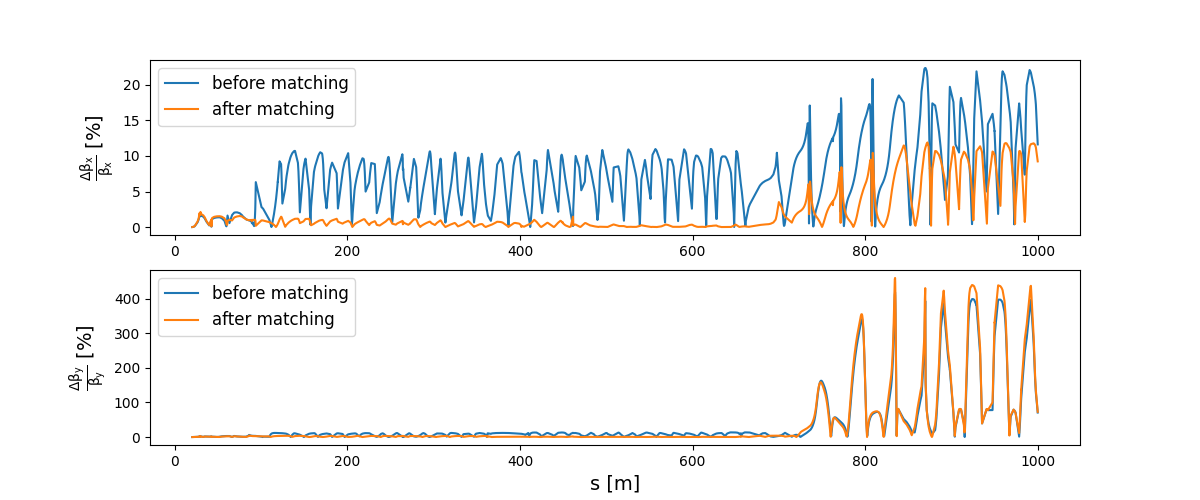

In [15]:
# Plot beta-beating before and after matching for comparison
fig, ax = plt.subplots(2, 1,figsize=(12, 5))

ax[0].plot(tw.s, bbetx_beforeMatching*100, label='before matching')
ax[0].plot(tw.s, bbetx_afterMatching*100, label='after matching')

ax[0].set_ylabel(r'$\frac{\Delta\mathrm{\beta}_\mathrm{x}}{\mathrm{\beta}_\mathrm{x}}$ [%]', fontsize=14)

ax[0].legend(fontsize=12)


ax[1].plot(tw.s, bbety_beforeMatching*100, label='before matching')
ax[1].plot(tw.s, bbety_afterMatching*100, label='after matching')

ax[1].set_ylabel(r'$\frac{\Delta\mathrm{\beta}_\mathrm{y}}{\mathrm{\beta}_\mathrm{y}}$ [%]', fontsize=14)

ax[1].set_xlabel('s [m]', fontsize=14)

ax[1].legend(fontsize=12)

plt.show()

In [28]:
# Save matched line
line.to_json('matched_lines/sler_1705_60_06_cw50_4b_firstMatching.json')

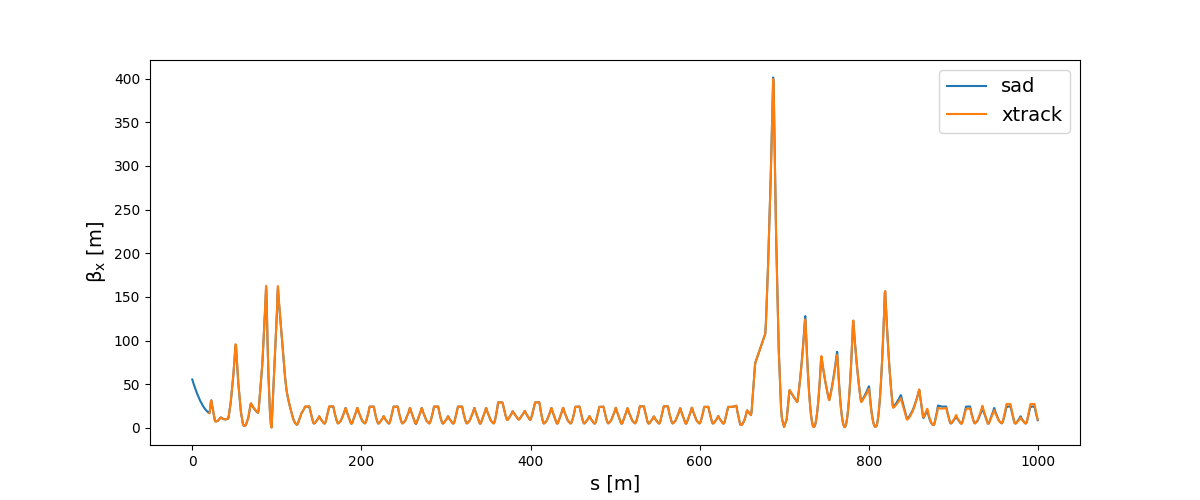

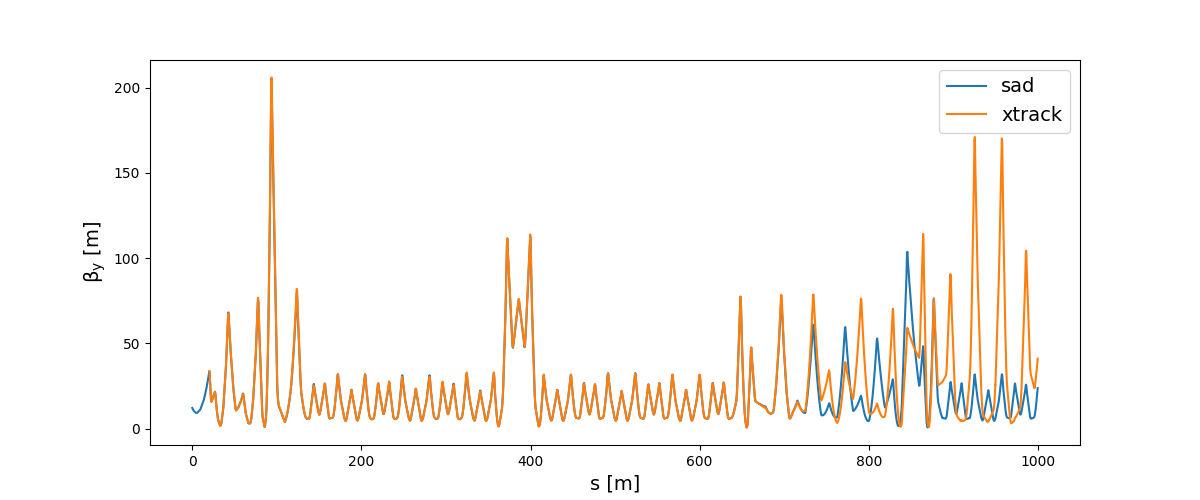

/tmp/ipykernel_9452/32723557.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 5))


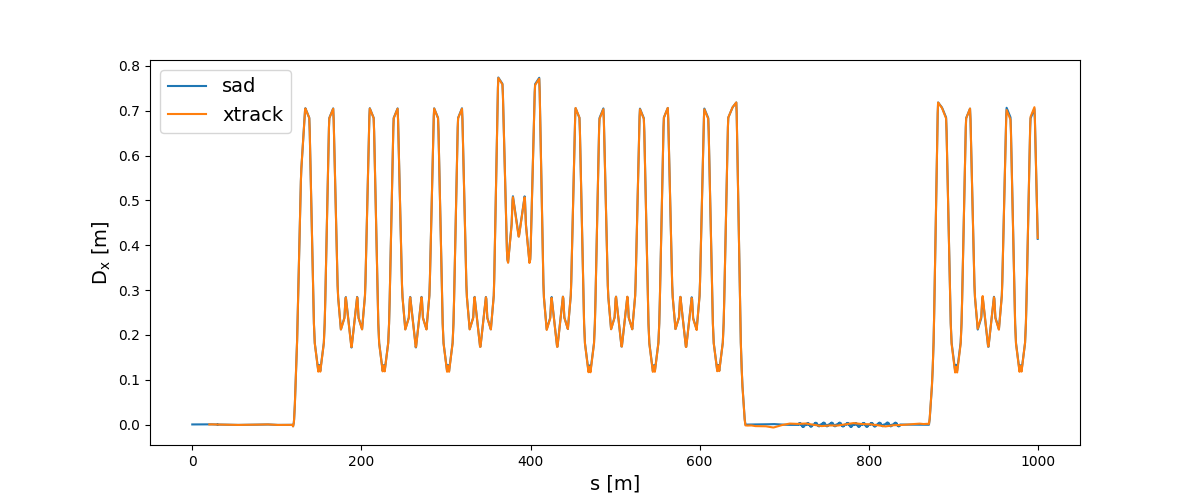

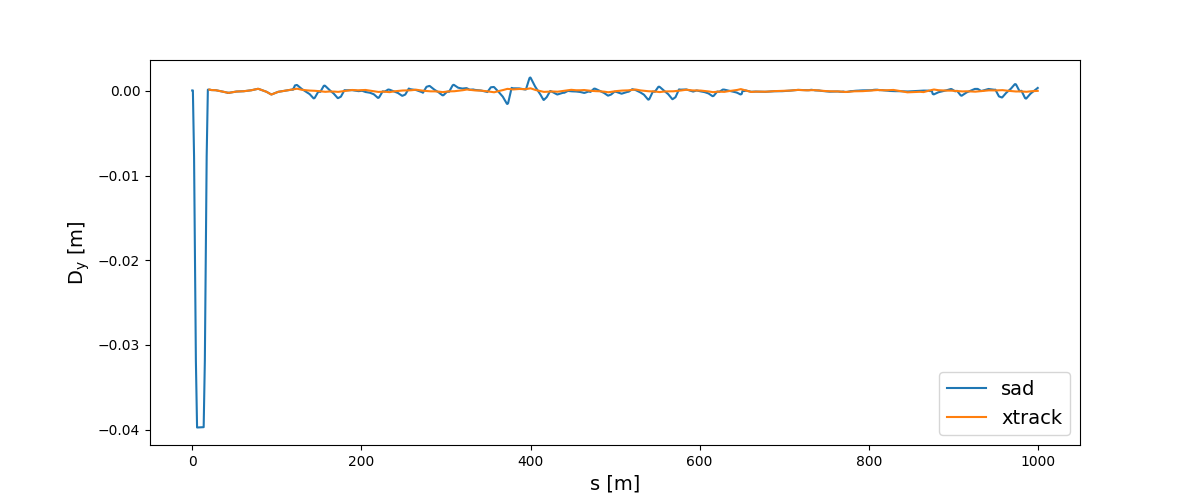

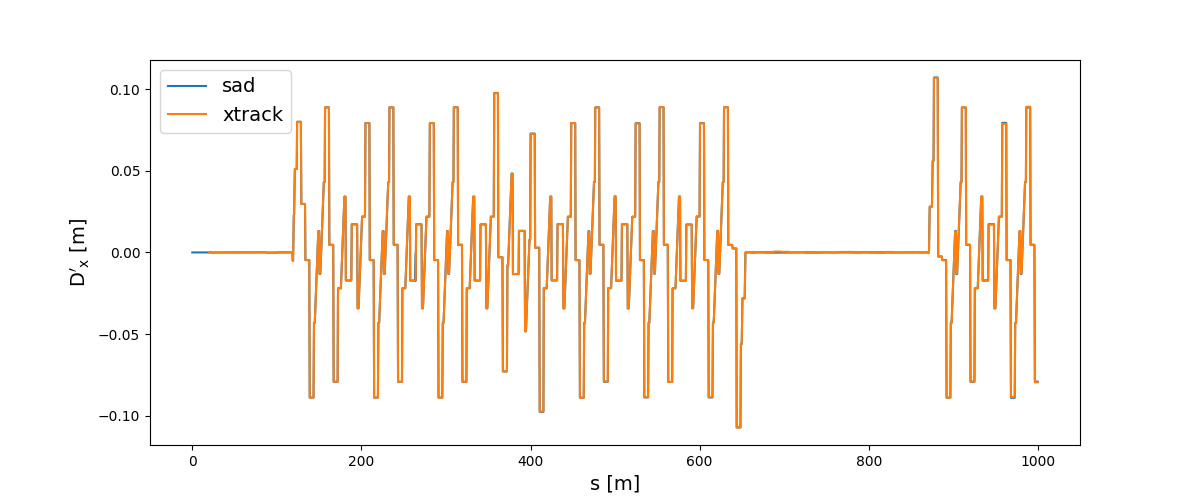

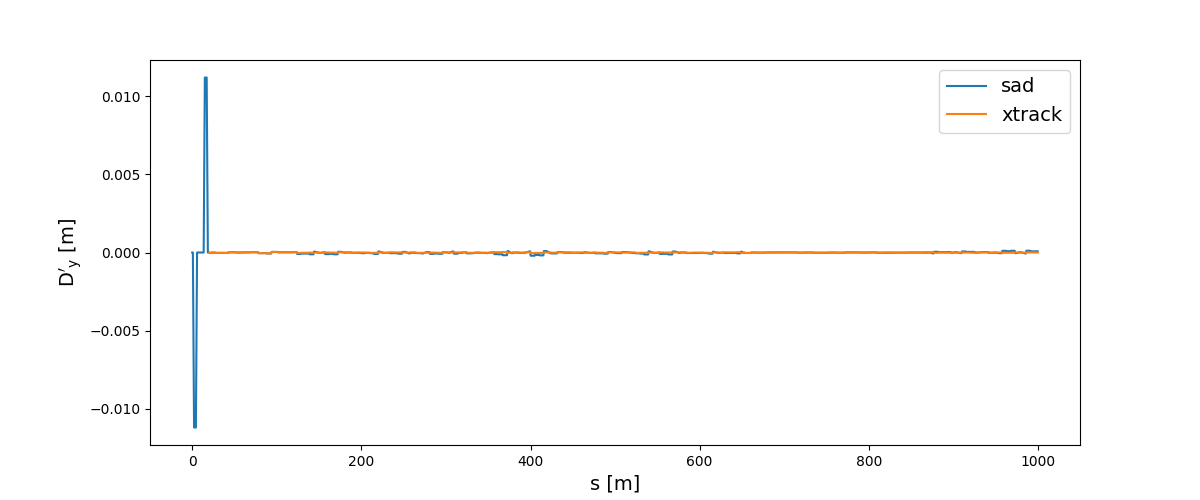

In [25]:
# Plot optics functions

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.betx, label='sad')
ax.plot(tw.s, tw.betx, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{\beta}_\mathrm{x}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()


fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.bety, label='sad')
ax.plot(tw.s, tw.bety, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{\beta}_\mathrm{y}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()


fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.dx, label='sad')
ax.plot(tw.s, tw.dx, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{D}_\mathrm{x}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()


fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.dy, label='sad')
ax.plot(tw.s, tw.dy, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{D}_\mathrm{y}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()


fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.dpx, label='sad')
ax.plot(tw.s, tw.dpx, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{D^\prime}_\mathrm{x}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()


fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(tw_sad.s, tw_sad.dpy, label='sad')
ax.plot(tw.s, tw.dpy, label='xtrack')

ax.set_xlabel('s [m]', fontsize=14)
ax.set_ylabel(r'$\mathrm{D^\prime}_\mathrm{y}$ [m]', fontsize=14)

plt.legend(fontsize=14)
plt.show()